# Achieving _equalized odds_ on real-world ACS data (ACSIncome)

**NOTE**: this notebook has extra requirements, install them with: ```pip install "error_parity[dev]"```

**DATA**: the data used in this notebook can be easily downloaded and parsed using the companion notebook `parse-folktables-datasets.ipynb`;

In [1]:
import logging
from itertools import product
from pathlib import Path

import pandas as pd
import numpy as np
import cvxpy as cp
from scipy.spatial import ConvexHull
from sklearn.metrics import roc_curve

In [2]:
from error_parity import __version__
print(f"Notebook ran using `error-parity=={__version__}`")

Notebook ran using `error-parity==0.3.11`


## Given some data (X, Y, S)

In [3]:
ACS_TASK = "ACSIncome"
SEED = 42

data_dir = Path("~").expanduser() / "data" / "folktables" / "train=0.6_test=0.2_validation=0.2_max-groups=4"

In [4]:
ACS_CATEGORICAL_COLS = {
    'COW',  # class of worker
    'MAR',  # marital status
    'OCCP', # occupation code
    'POBP', # place of birth code
    'RELP', # relationship status
    'SEX',
    'RAC1P', # race code
    'DIS',  # disability
    'ESP',  # employment status of parents
    'CIT',  # citizenship status
    'MIG',  # mobility status
    'MIL',  # military service
    'ANC',  # ancestry
    'NATIVITY',
    'DEAR',
    'DEYE',
    'DREM',
    'ESR',
    'ST',
    'FER',
    'GCL',
    'JWTR',
#     'PUMA',
#     'POWPUMA',
}

In [5]:
import folktables

def split_X_Y_S(data, label_col: str, sensitive_col: str, ignore_cols=None, unawareness=False) -> tuple:
    ignore_cols = ignore_cols or []
    ignore_cols.append(label_col)
    if unawareness:
        ignore_cols.append(sensitive_col)
    
    feature_cols = [c for c in data.columns if c not in ignore_cols]
    
    return (
        data[feature_cols],                           # X
        data[label_col].to_numpy().astype(int),       # Y
        data[sensitive_col].to_numpy().astype(int),   # S
    )

def load_ACS_data(dir_path: str, task_name: str, sensitive_col: str = None) -> pd.DataFrame:
    """Loads the given ACS task data from pre-generated datasets.

    Returns
    -------
    dict[str, tuple]
        A list of tuples, each tuple composed of (features, label, sensitive_attribute).
        The list is sorted as follows" [<train data tuple>, <test data tuple>, <val. data tuple>].
    """
    # Load task object
    task_obj = getattr(folktables, task_name)

    # Load train, test, and validation data
    data = dict()
    for data_type in ['train', 'test', 'validation']:
        # Construct file path
        path = Path(dir_path) / f"{task_name}.{data_type}.csv"
        
        if not path.exists():
            print(f"Couldn't find data for '{path.name}' (this is probably expected).")
            continue

        # Read data from disk
        df = pd.read_csv(path, index_col=0)

        # Set categorical columns
        cat_cols = ACS_CATEGORICAL_COLS & set(df.columns)
        df = df.astype({col: "category" for col in cat_cols})
        
        data[data_type] = split_X_Y_S(
            df,
            label_col=task_obj.target,
            sensitive_col=sensitive_col or task_obj.group,
        )

    return data

In [6]:
# Load and pre-process data
all_data = load_ACS_data(
    dir_path=data_dir, task_name=ACS_TASK,
)

# Unpack into features, label, and group
X_train, y_train, s_train = all_data["train"]
X_test, y_test, s_test = all_data["test"]
if "validation" in all_data:
    X_val, y_val, s_val = all_data["validation"]
else:
    print("No validation data.")

In [7]:
n_groups = len(np.unique(s_train))

In [8]:
actual_prevalence = np.sum(y_train) / len(y_train)
print(f"Global prevalence: {actual_prevalence:.1%}")

Global prevalence: 37.2%


In [9]:
EPSILON_TOLERANCE = 0.05

FALSE_POS_COST = 1
FALSE_NEG_COST = 1

L_P_NORM = np.inf         # constrain l-infinity distance between ROC points
# L_P_NORM = 1            # constrain l-1 distance between ROC points
# L_P_NORM = 2            # constrain l-2 distance between ROC points

---
## Given a trained predictor (that outputs real-valued scores)

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_jobs=-2)

In [11]:
%%time
rf_clf.fit(X_train, y_train)

CPU times: user 1min 46s, sys: 1.81 s, total: 1min 47s
Wall time: 13.7 s


RandomForestClassifier(n_jobs=-2)

In [12]:
predictor = lambda X: rf_clf.predict_proba(X)[:, -1]

## Construct the fair optimal classifier (derived from the given predictor)
- Fairness is measured by the equal odds constraint (equal FPR and TPR among groups);
    - optionally, this constraint can be relaxed by some small tolerance;
    - the type of relaxation can be changed using the `l_p_norm` key-word argument (default is `l_p_norm=np.inf`);
- Optimality is measured as minimizing the expected loss while fulfilling the fairness constraint,
    - parameterized by the given cost of false positive and false negative errors;

In [13]:
if "validation" in all_data:
    X_fit, y_fit, s_fit = X_val, y_val, s_val
else:
    X_fit, y_fit, s_fit = X_train, y_train, s_train

In [14]:
from error_parity import RelaxedThresholdOptimizer

postproc_clf = RelaxedThresholdOptimizer(
    predictor=predictor,
    constraint="equalized_odds",
    tolerance=EPSILON_TOLERANCE,
    false_pos_cost=FALSE_POS_COST,
    false_neg_cost=FALSE_NEG_COST,
    l_p_norm=L_P_NORM,
    seed=SEED,
)

In [15]:
%%time
import logging
logging.basicConfig(level=logging.INFO, force=True)
postproc_clf.fit(X=X_fit, y=y_fit, group=s_fit)

INFO:root:ROC convex hull contains 8.7% of the original points.
INFO:root:ROC convex hull contains 10.8% of the original points.
INFO:root:ROC convex hull contains 6.0% of the original points.
INFO:root:ROC convex hull contains 9.6% of the original points.
INFO:root:cvxpy solver took 0.00044025s; status is optimal.
INFO:root:Optimal solution value: 0.201182803373743
INFO:root:Variable Global ROC point: value [0.14162381 0.69846535]
INFO:root:Variable ROC point for group 0: value [0.14576582 0.70242546]
INFO:root:Variable ROC point for group 1: value [0.12760711 0.65242546]
INFO:root:Variable ROC point for group 2: value [0.10263456 0.70242546]
INFO:root:Variable ROC point for group 3: value [0.14840647 0.65242546]


CPU times: user 14.9 s, sys: 218 ms, total: 15.1 s
Wall time: 2.14 s


## Plot solution

In [16]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", rc={'grid.linestyle': ':'})

In [17]:
all_groups_name_map = {
    0: "White",
    1: "Black",
    2: "American Indian",
    3: "Alaska Native",
    4: "American Indian",
    5: "Asian",
    6: "Native Hawaiian",
    7: "other single race",
    8: "other multiple races",
}

largest_groups_name_map = {
    0: "White",
    1: "Black",
    2: "Asian",
    3: "other",
}

group_name_map=all_groups_name_map if len(np.unique(s_fit)) > len(largest_groups_name_map) else largest_groups_name_map

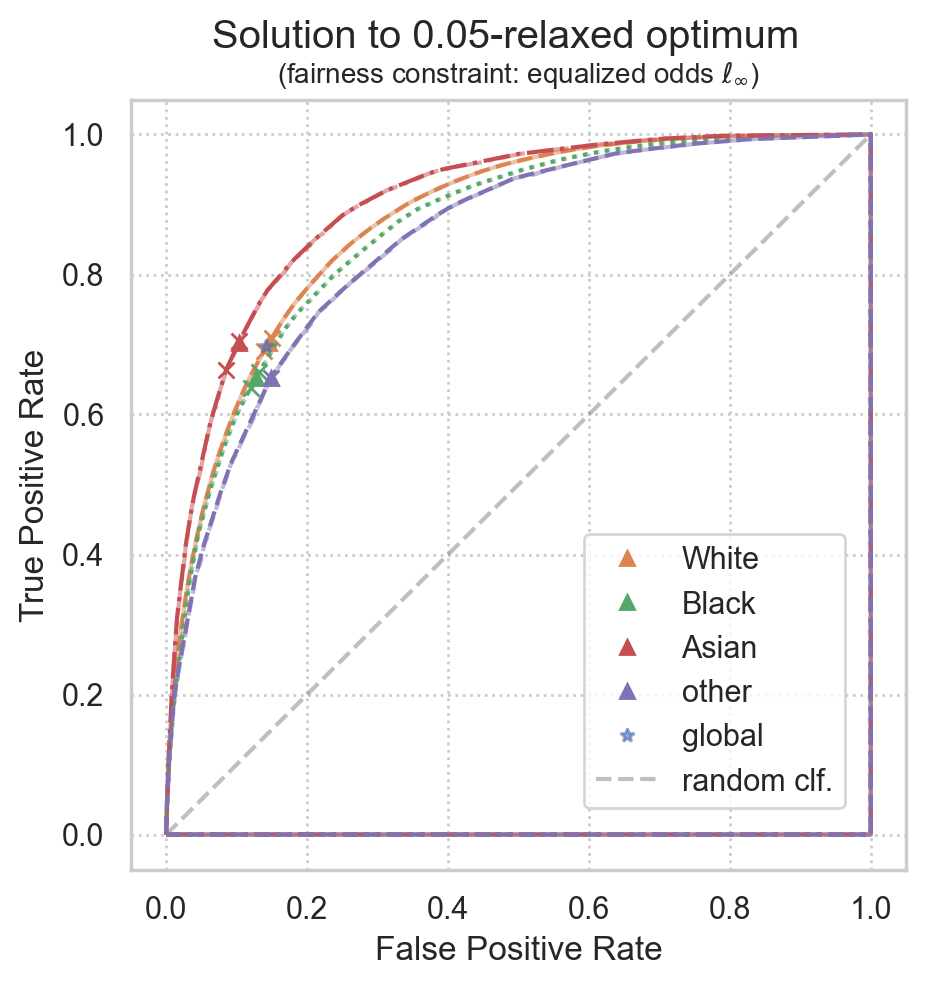

In [18]:
from error_parity.plotting import plot_postprocessing_solution
plot_postprocessing_solution(
    postprocessed_clf=postproc_clf,
    plot_roc_curves=True,
    plot_roc_hulls=True,
    dpi=200, figsize=(5, 5),
    group_name_map=group_name_map,
)
plt.show()

#### Theoretical results:

In [19]:
acc_val = 1 - postproc_clf.cost(1.0, 1.0)
unf_val = postproc_clf.constraint_violation()

print(f"Accuracy:   {acc_val:.1%}")
print(f"Unfairness: {unf_val:.1%} <= {EPSILON_TOLERANCE:.1%}")

INFO:root:Maximum fairness violation is between group=0 (p=[0.14576582 0.70242546]) and group=3 (p=[0.14840647 0.65242546]);


Accuracy:   79.9%
Unfairness: 5.0% <= 5.0%


---
## Plot realized ROC points
> Realized ROC points will converge to the theoretical solution for larger datasets, but some variance is expected for smaller datasets.

In [20]:
# Set group-wise colors and global color
palette = sns.color_palette(n_colors=n_groups + 1)
global_color = palette[0]
all_group_colors = palette[1:]

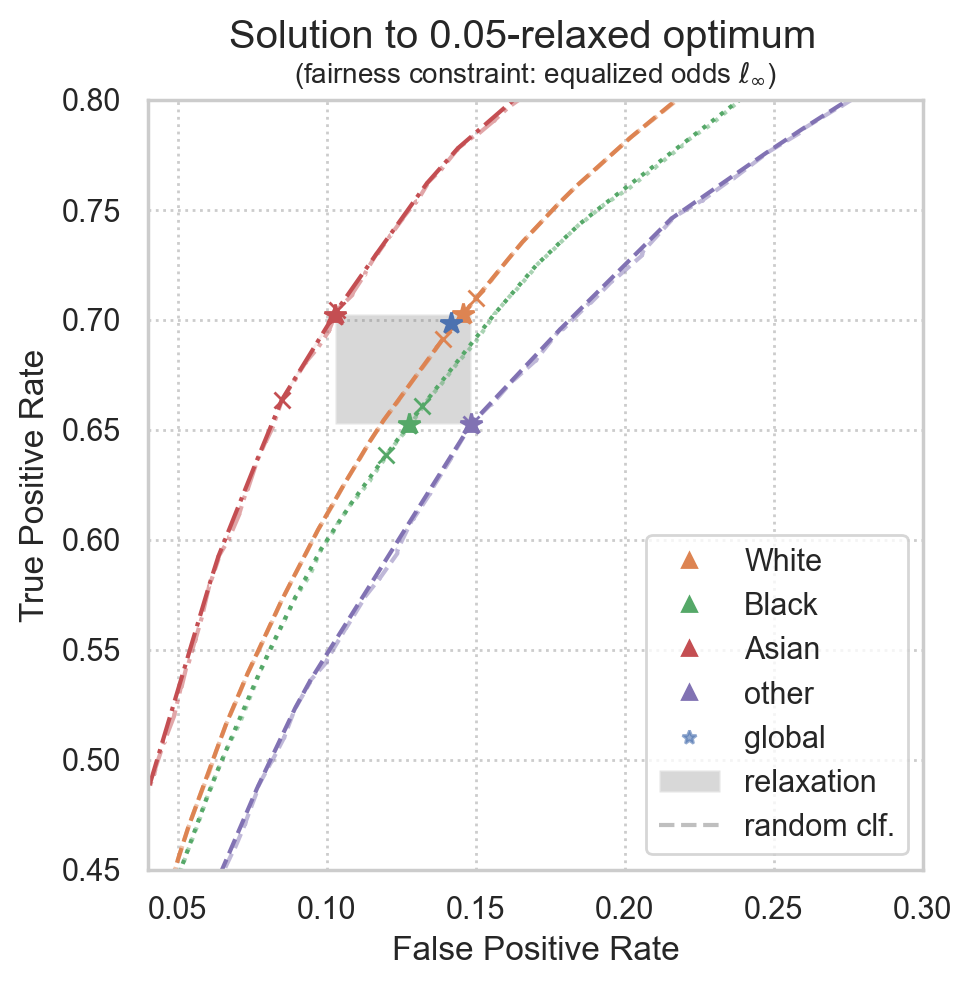

In [21]:
from error_parity.roc_utils import compute_roc_point_from_predictions

plot_postprocessing_solution(
    postprocessed_clf=postproc_clf,
    plot_roc_curves=True,
    plot_roc_hulls=True,
    plot_relaxation=True,
    dpi=200, figsize=(5, 5),
    group_name_map=group_name_map,
)

# Compute predictions
y_fit_preds = postproc_clf(X_fit, group=s_fit)

# Plot the group-wise points found
realized_roc_points = list()
for idx in range(n_groups):

    # Evaluate triangulation of target point as a randomized clf
    group_filter = s_fit == idx

    curr_realized_roc_point = compute_roc_point_from_predictions(y_fit[group_filter], y_fit_preds[group_filter])
    realized_roc_points.append(curr_realized_roc_point)

    plt.plot(
        curr_realized_roc_point[0], curr_realized_roc_point[1],
        color=all_group_colors[idx],
        marker="*", markersize=8,
        lw=0,
    )

realized_roc_points = np.vstack(realized_roc_points)

# Plot actual global classifier performance
global_clf_realized_roc_point = compute_roc_point_from_predictions(y_fit, y_fit_preds)
plt.plot(
    global_clf_realized_roc_point[0], global_clf_realized_roc_point[1],
    color=global_color,
    marker="*", markersize=8,
    lw=0,
)

plt.xlim(0.04, 0.3)
plt.ylim(0.45, 0.80)
plt.legend()

plt.show()

### Compute differences between theoretical ROC points and empirical ROC points

In [22]:
# Distances to group-wise targets:
for i, (target_point, actual_point) in enumerate(zip(postproc_clf.groupwise_roc_points, realized_roc_points)):
    dist = np.linalg.norm(target_point - actual_point, ord=2)
    print(f"Group {i}: l2 distance from target to realized point := {dist:.3%} (size={np.sum(s_fit==i)})")

# Distance to global target point:
dist = np.linalg.norm(postproc_clf.global_roc_point - global_clf_realized_roc_point, ord=2)
print(f"Global l2 distance from target to realized point   := {dist:.3%}")

Group 0: l2 distance from target to realized point := 0.010% (size=259521)
Group 1: l2 distance from target to realized point := 0.017% (size=29518)
Group 2: l2 distance from target to realized point := 0.052% (size=19386)
Group 3: l2 distance from target to realized point := 0.000% (size=12570)
Global l2 distance from target to realized point   := 0.007%


### Compute difference between theoretical performance and empirical performance
> assumes FP_cost == FN_cost == 1.0

In [23]:
from sklearn.metrics import accuracy_score
from error_parity.roc_utils import calc_cost_of_point

# Empirical accuracy
accuracy_fit = accuracy_score(y_fit, y_fit_preds)

print(f"Actual accuracy: \t\t{accuracy_fit:.3%}")
print(f"Actual error rate (1 - Acc.):\t{1 - accuracy_fit:.3%}")
print(f"Theoretical error rate:\t\t{postproc_clf.cost(1.0, 1.0):.3%}")

Actual accuracy: 		79.886%
Actual error rate (1 - Acc.):	20.114%
Theoretical error rate:		20.118%


---

### Best non-fairness-constrained single-threshold solution

In [24]:
from tqdm.auto import tqdm

# Compute prediction scores
y_test_scores = predictor(X_test)

acc_unfair_best, acc_unfair_threshold = max((accuracy_score(y_test, y_test_scores >= t), t) for t in tqdm(np.arange(0, 1, 2e-2)))
print(f"Best (train) unfair accuracy is {acc_unfair_best:.3%}, with threshold t={acc_unfair_threshold}")

  0%|          | 0/50 [00:00<?, ?it/s]

Best (train) unfair accuracy is 80.208%, with threshold t=0.48


In [25]:
from error_parity.evaluation import eval_accuracy_and_equalized_odds
print("Best (unconstrained) single-threshold classifier:")

eval_accuracy_and_equalized_odds(
    y_true=y_test,
    y_pred_binary=predictor(X_test) >= acc_unfair_threshold,
    sensitive_attr=s_test,
    l_p_norm=L_P_NORM,
    display=True,
)

print("Best (constrained) multi-threshold classifier:")
eval_accuracy_and_equalized_odds(
    y_true=y_test,
    y_pred_binary=postproc_clf(X_test, group=s_test),
    sensitive_attr=s_test,
    l_p_norm=L_P_NORM,
    display=True,
);

Best (unconstrained) single-threshold classifier:
	Accuracy:   80.21%
	Unfairness: 35.50%
Best (constrained) multi-threshold classifier:
	Accuracy:   79.90%
	Unfairness: 8.10%


# Fairness vs Performance trade-off

Plotting the entire Pareto frontier **may take a few minutes...**

In [26]:
from error_parity.pareto_curve import compute_postprocessing_curve

postproc_results_df = compute_postprocessing_curve(
    model=rf_clf,
    fit_data=(X_fit, y_fit, s_fit),
    eval_data={
        "test": (X_test, y_test, s_test),
    },
    fairness_constraint="equalized_odds",
    l_p_norm=L_P_NORM,
    tolerance_ticks=np.hstack((
        np.arange(0.0, 0.1, 1e-2),
        np.arange(0.1, 1.0, 1e-1),
    )),
    bootstrap=True,
    seed=SEED,
)

INFO:root:Using `n_jobs=9` to compute adjustment curve.
INFO:root:Computing postprocessing for the following constraint tolerances: [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.2  0.3  0.4
 0.5  0.6  0.7  0.8  0.9 ].


  0%|          | 0/19 [00:00<?, ?it/s]

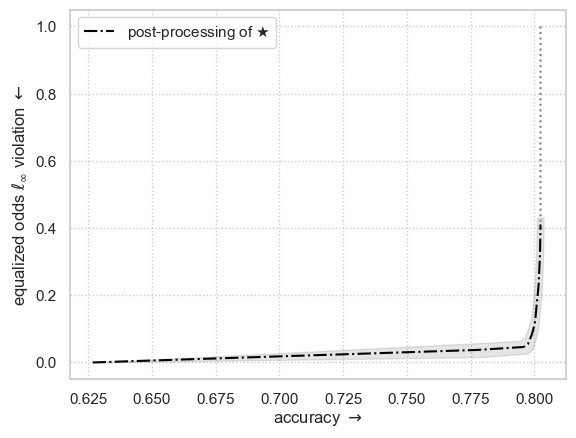

In [27]:
from error_parity.plotting import plot_postprocessing_frontier
from matplotlib import pyplot as plt

plot_postprocessing_frontier(
    postproc_results_df,
    perf_metric="accuracy",
    disp_metric=f"equalized_odds_diff_l{postproc_clf.l_p_norm}",
    show_data_type="test",
    constant_clf_perf=max((y_test == const_pred).mean() for const_pred in {0, 1}),
    model_name=r"$\bigstar$",
)

plt.xlabel(r"accuracy $\rightarrow$")
l_p_norm_str = str(postproc_clf.l_p_norm) if postproc_clf.l_p_norm != np.inf else r"\infty"
plt.ylabel(r"equalized odds $\ell_" + l_p_norm_str + r"$ violation $\leftarrow$")
plt.show()

---
# Fit and plot similar example but using "Equal Opportunity" fairness metric
> equal opportunity is achieved by setting `fairness_constraint="true_positive_rate_parity"`

In [28]:
from error_parity.pareto_curve import compute_postprocessing_curve

postproc_results_df = compute_postprocessing_curve(
    model=rf_clf,
    fit_data=(X_fit, y_fit, s_fit),
    eval_data={
        "test": (X_test, y_test, s_test),
    },
    fairness_constraint="true_positive_rate_parity",
    tolerance_ticks=np.hstack((
        np.arange(0.0, 0.1, 1e-2),
        np.arange(0.1, 1.0, 1e-1),
    )),
    bootstrap=True,
    seed=SEED,
)

  0%|          | 0/19 [00:00<?, ?it/s]

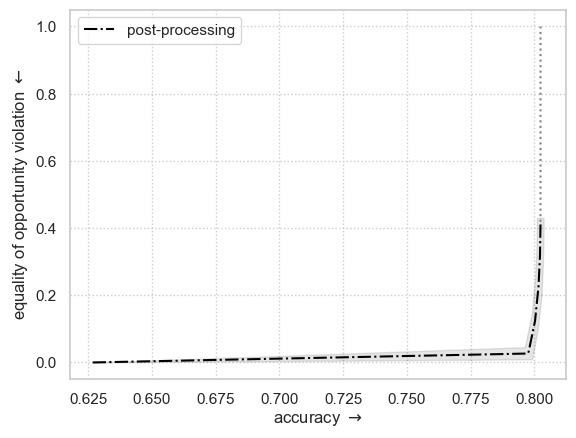

In [29]:
plot_postprocessing_frontier(
    postproc_results_df,
    perf_metric="accuracy",
    disp_metric="tpr_diff",
    show_data_type="test",
    constant_clf_perf=max((y_test == const_pred).mean() for const_pred in {0, 1}),
)

plt.xlabel(r"accuracy $\rightarrow$")
plt.ylabel(r"equality of opportunity violation $\leftarrow$")
plt.show()